# Содержание

- [Введение](#введение)
- [Установка библиотек и импорт](#установка-библиотек-и-импорт)
- [Загрузка данных](#загрузка-данных)
- Exploratory Data Analysis
  - [Анализ распределения длительности поездок](#анализ-распределения-длительности-поездок)
  - [Обработка временного признака](#обработка-временного-признака)
  - [Изучаем координаты](#изучаем-координаты)
  - [Изучаем среднюю скорость движения](#изучаем-среднюю-скорость-движения)
  - [Определение точек с аномальными координатами](#определение-точек-с-аномальными-координатами)
  - [Разбиение области Манхэттена на карте на ячейки](#разбиение-области-манхэттена-на-карте-на-ячейки)
  - [Изучаем оставшиеся признаки](#изучаем-оставшиеся-признаки)
- Feature Engineering
  - [Feature Engineering](#feature-engineering)
  - [Манхэттенское расстояние](#манхэттенское-расстояние)
- Моделирование
  - [Моделирование: линейная регрессия с регуляризацией](#моделирование-линейная-регрессия-с-регуляризацией)
  - [Улучшаем модель](#улучшаем-модель)
  - [Улучшение модели: Random Forest](#улучшение-модели-random-forest)
- [Выводы](#выводы)

# Анализ и предсказание длительности поездок на такси в Нью-Йорке

## Введение
Этот проект основан на данных из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration). Цель — провести EDA, выделить полезные признаки и создать новые и построить модели для предсказания длительности поездок. Мы используем линейную регрессию с регуляризацией (Lasso и Ridge), а в конце улучшим результаты с помощью случайного леса.

Данные: Обучающая выборка с информацией о поездках из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration), в котором нужно было предсказать длительность поездки на такси.

Метрика качества:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

## Установка библиотек и импорт

In [1]:
!pip install folium

import folium
import warnings
warnings.simplefilter('ignore')

import pandas as pd
pd.plotting.register_matplotlib_converters()
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import pyplot as plt

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

## Загрузка данных
Скачиваем и загружаем обучающую выборку из соревнования.

In [2]:
!wget -O 'train_csv' -q "https://www.dropbox.com/scl/fi/pfqirovmg74oea30xtl00/train-3.csv?rlkey=q95av7pl6bvq0xu4c4jr8q1ti&st=x1a88i53&dl=0"

In [3]:
train_data = pd.read_csv('train_csv')

train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
train_data.dtypes

,0
id,object
vendor_id,int64
pickup_datetime,object
dropoff_datetime,object
passenger_count,int64
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
store_and_fwd_flag,object


Колонка `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, поэтому удалим ее.

В `pickup_datetime` записаны дата и время начала поездки. Чтобы с этой колонкой было удобно работать, преобразуем даты в `datetime`-объектыю

In [5]:
train_data.drop(columns=['dropoff_datetime'], inplace=True)
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])

In [6]:
train_data.shape

(1458644, 10)

In [7]:
train_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

In [8]:
train_data.isna().sum()

,0
id,0
vendor_id,0
pickup_datetime,0
passenger_count,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
store_and_fwd_flag,0
trip_duration,0


## Exploratory Data Analysis

### Анализ распределения длительности поездок
Преобразуем таргет в логарифмическую шкалу для лучшей моделирования.

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Посмотрим на распределение таргета в обучающей выборке.

Text(0.5, 1.0, 'Distribution of trip_duration')

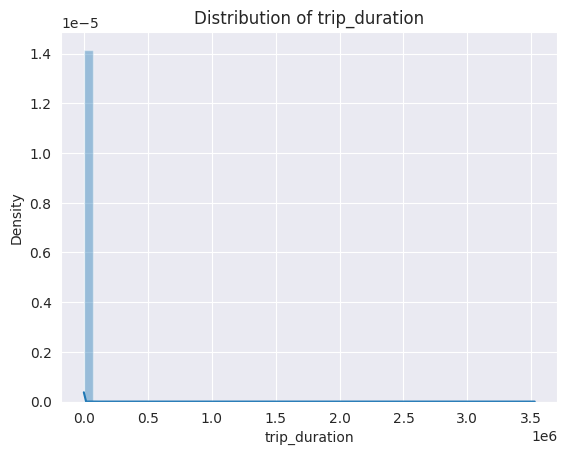

In [9]:
sns.distplot(train_data['trip_duration'])
plt.title("Distribution of trip_duration")

Распределение скошено вправо, много коротких поездок, редкие длинные.


Будем предсказывать не целевую переменную, а ее логарифм. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$. И тогда задача оптимизации RMSLE получается сведенной к задаче оптимизации RMSE

In [10]:
train_data['log_trip_duration'] = np.log1p(train_data['trip_duration'])
train_data.drop(columns=['trip_duration'], inplace=True)

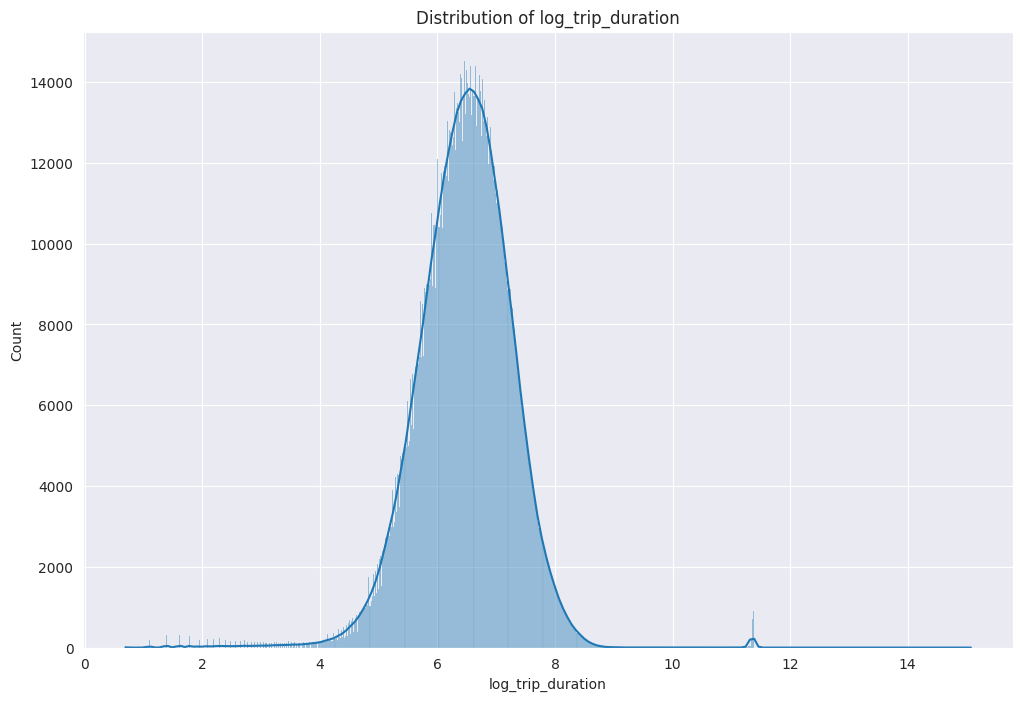

In [11]:
plt.figure(figsize=(12,8))
sns.histplot(train_data['log_trip_duration'], kde=True)
plt.title("Distribution of log_trip_duration")
plt.show()

Заметим, что у логарифмирования таргета есть одно полезное свойство: логарифмирование приближает распределение целевой переменной к нормальному.

Чтобы иметь некоторую точку отсчета, посчитаем значение метрики при наилучшем константном предсказании

In [12]:
best_constant = train_data['log_trip_duration'].mean()
print("Full train_data RMSLE with best constant = %.4f" % np.sqrt(mean_squared_error(train_data['log_trip_duration'], best_constant * np.ones(train_data['log_trip_duration'].shape))))

Full train_data RMSLE with best constant = 0.7958


### Обработка временного признака
Посмотрим, сколько всего было поездок в каждый из дней

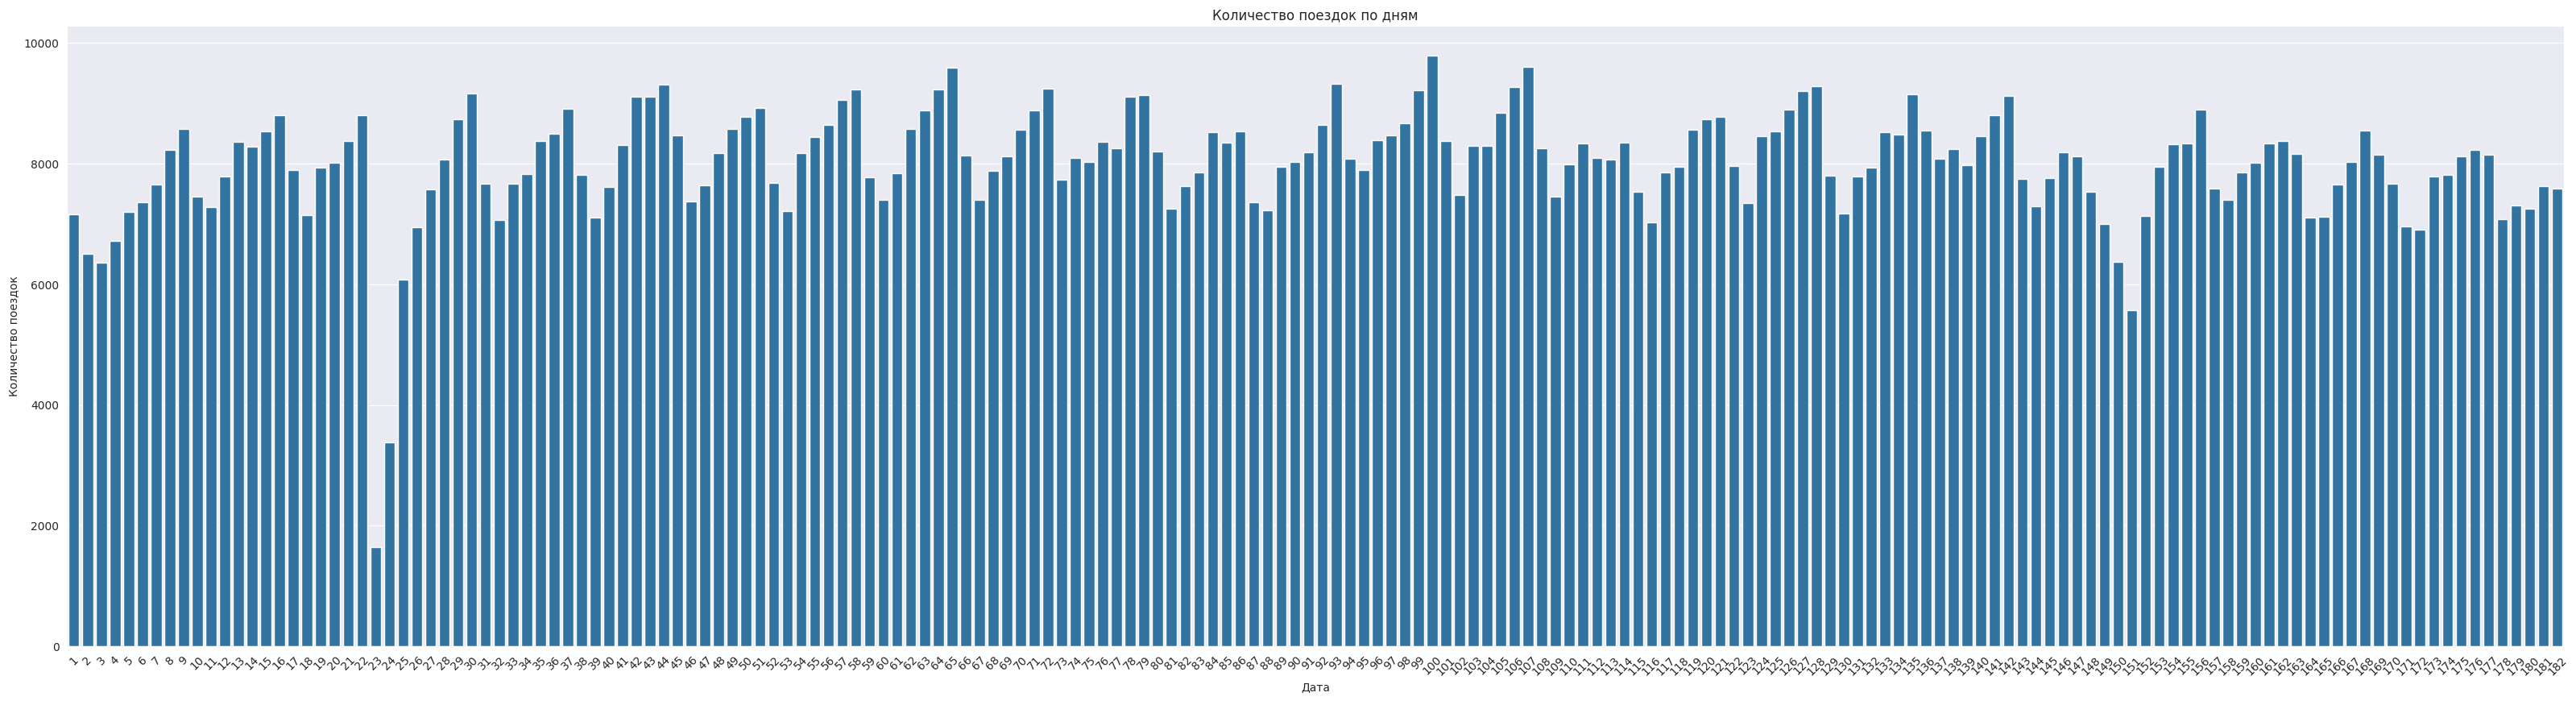

In [13]:
train_data['dayofyear'] = train_data['pickup_datetime'].dt.dayofyear
plt.figure(figsize=(40,10))
sns.countplot(x = train_data['dayofyear'])
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Количество поездок')
plt.title('Количество поездок по дням')
plt.show()

На графике есть 2 периода с аномально маленькими количествами поездок. Эти скачки вниз происходили 23-25 января и 29-30 мая 2016 - снежная буря Jonas и Memorial Day с погодными условиями.

In [14]:
train_data['anomal_day'] = train_data['dayofyear'].apply(lambda x: 1 if x in (23, 24, 25, 150, 151) else 0)

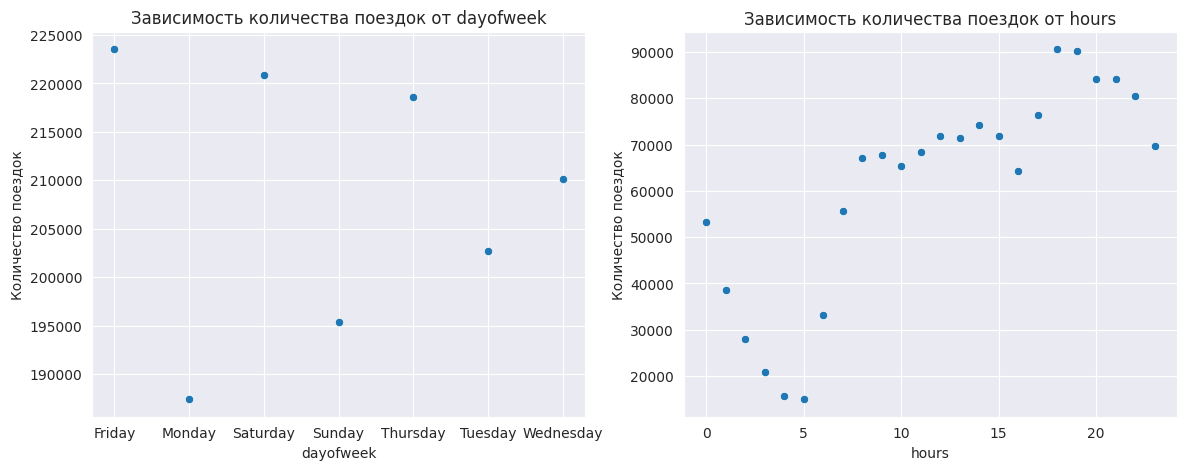

In [15]:
train_data['dayofweek'] = train_data['pickup_datetime'].dt.day_name()
train_data['hours'] = train_data['pickup_datetime'].dt.hour

fig, axs = plt.subplots(figsize=(14,5), ncols=2)
for i, feature in enumerate(['dayofweek', 'hours']):
  sns.scatterplot(x = feature, y = 'cnt_trips', data = train_data.groupby(feature).size().reset_index(name='cnt_trips'), ax = axs[i])
  axs[i].set_xlabel(feature)
  axs[i].set_ylabel("Количество поездок")
  axs[i].set_title(f"Зависимость количества поездок от {feature}")

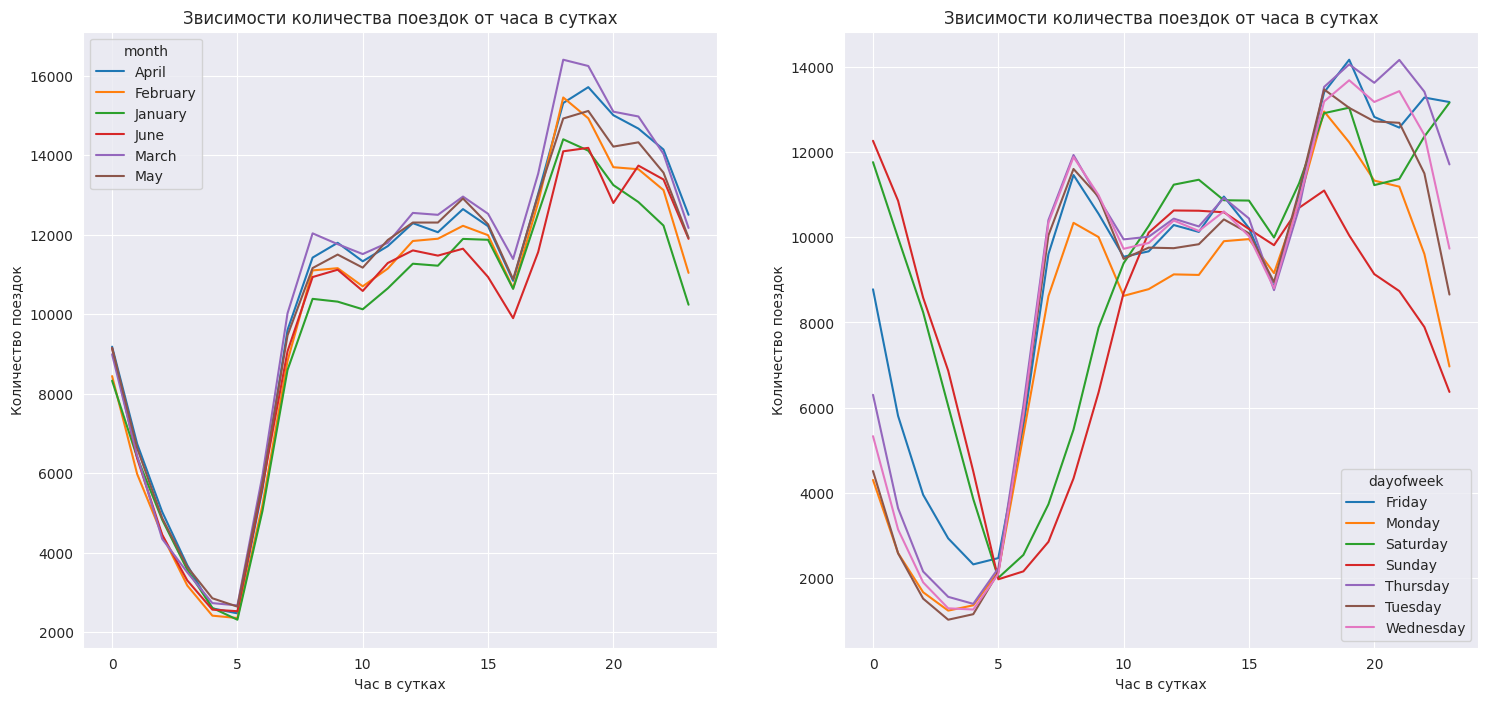

In [16]:
train_data['month'] = train_data['pickup_datetime'].dt.month_name()
fig, axs = plt.subplots(figsize=(18, 8), ncols=2)
for i, feature in enumerate(['month', 'dayofweek']):
  sns.lineplot(x = 'hours', y = 'cnt_trips', data = train_data.groupby(['hours', feature]).size().reset_index(name='cnt_trips'), hue = feature, ax = axs[i])
  axs[i].set_xlabel("Час в сутках")
  axs[i].set_ylabel("Количество поездок")
  axs[i].set_title(f"Звисимости количества поездок от часа в сутках")

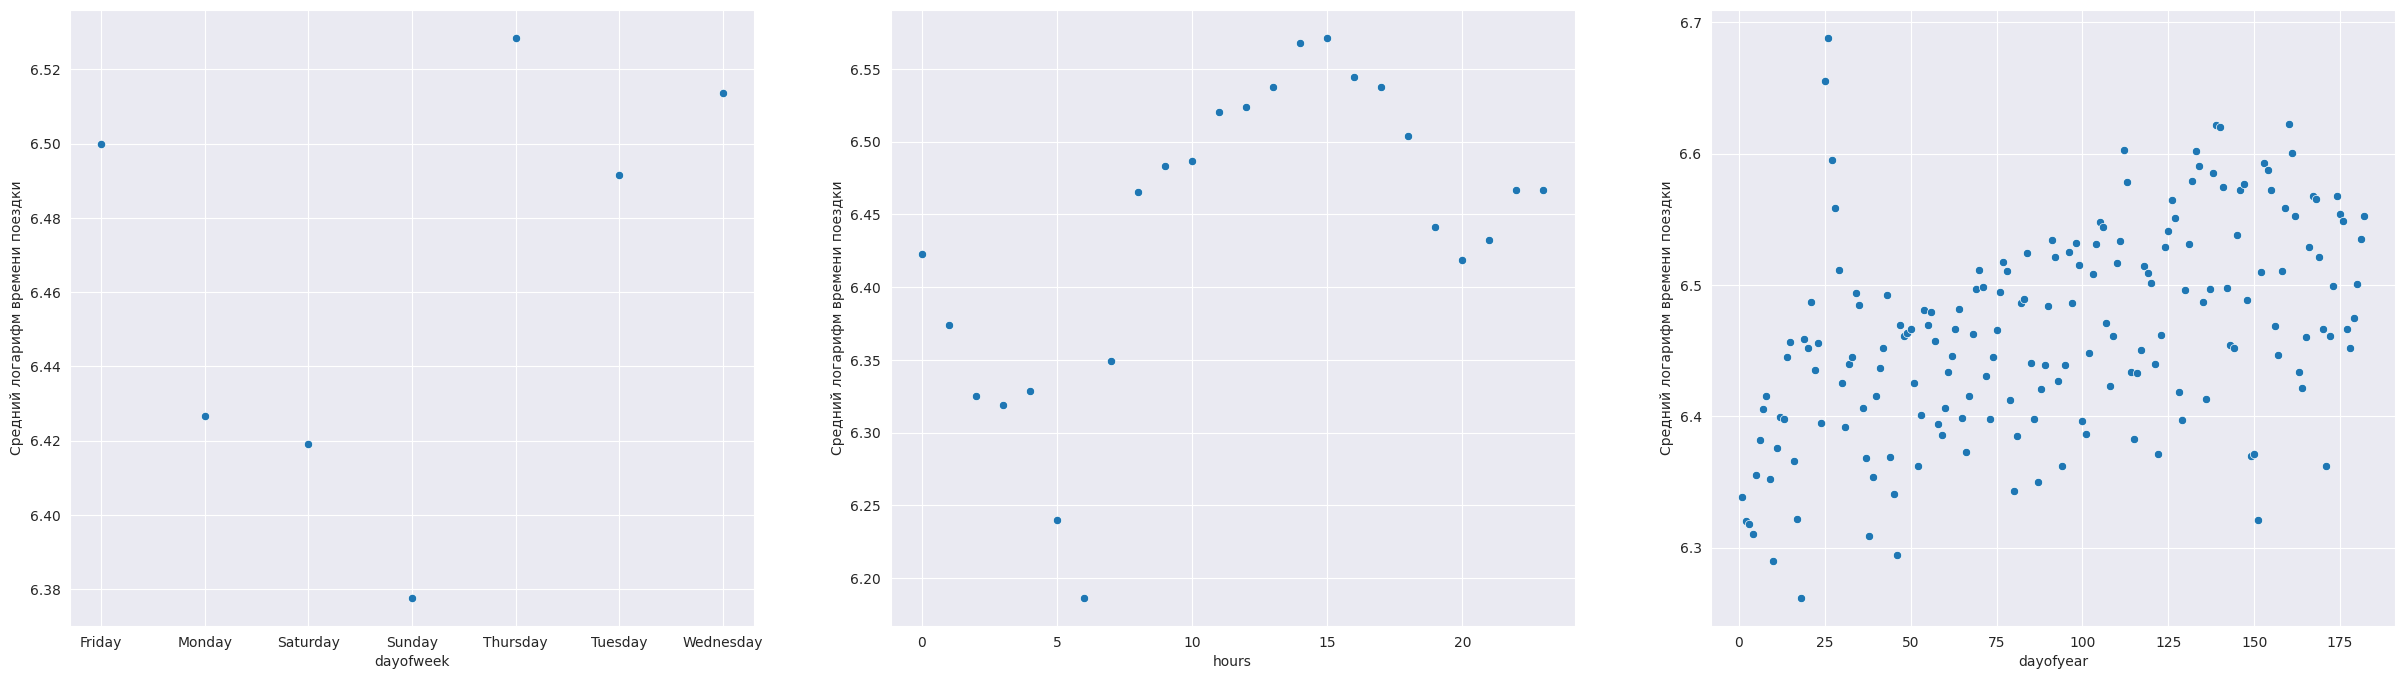

In [17]:
fig, axs = plt.subplots(figsize=(30,8), ncols=3)
for i, feature in enumerate(['dayofweek', 'hours', 'dayofyear']):
  sns.scatterplot(x = feature, y = 'avg_log', data = train_data.groupby(feature)['log_trip_duration'].mean().reset_index(name = 'avg_log'), ax = axs[i])
  axs[i].set_xlabel(feature)
  axs[i].set_ylabel("Средний логарифм времени поездки")

Таким образом, добавены следующие признаки:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (бинарный признака, соответствующие двум аномальным периодам сразу)
5. Номер дня в году

### Изучаем координаты

In [18]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [19]:
show_circles_on_map(train_data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [20]:
show_circles_on_map(train_data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

Очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки.

In [21]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

train_data.loc[:, 'haversine'] = haversine_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

Мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние.

In [22]:
train_data['log_haversine'] = np.log1p(train_data['haversine'])

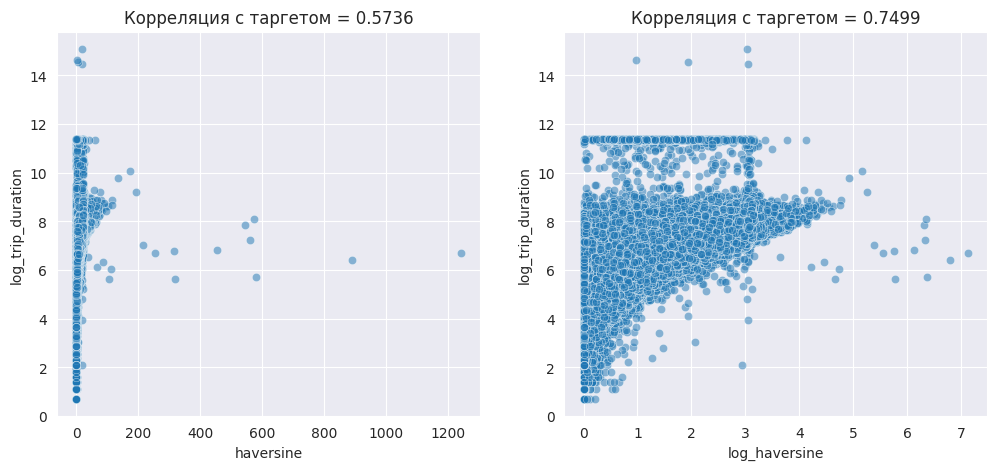

In [23]:
correlations = train_data[['haversine', 'log_haversine']].corrwith(train_data['log_trip_duration'])
fig, axs = plt.subplots(figsize = (12,5), ncols = 2)
for i, feature in enumerate(['haversine', 'log_haversine']):
  sns.scatterplot(x=train_data[feature], y = train_data['log_trip_duration'], ax = axs[i], alpha = 0.5)
  axs[i].set_xlabel(feature)
  axs[i].set_title(f'Корреляция c таргетом = %.4f' % correlations.loc[feature])

Заметим, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние.

### Изучаем среднюю скорость движения

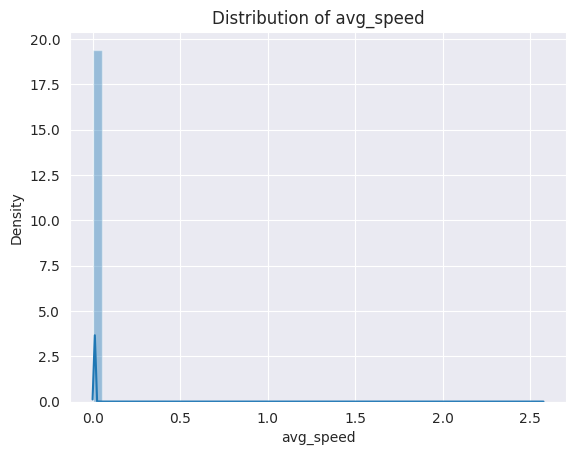

In [24]:
train_data['avg_speed'] = train_data['haversine'] / (np.exp(train_data['log_trip_duration'])-1)

sns.distplot(train_data['avg_speed'])
plt.title("Distribution of avg_speed")
plt.show()

Для некоторых объектов у нас получились очень больше значения скоростей. Посмотрим на гистограмму по объектам, для которых значение скорости получилось разумным:

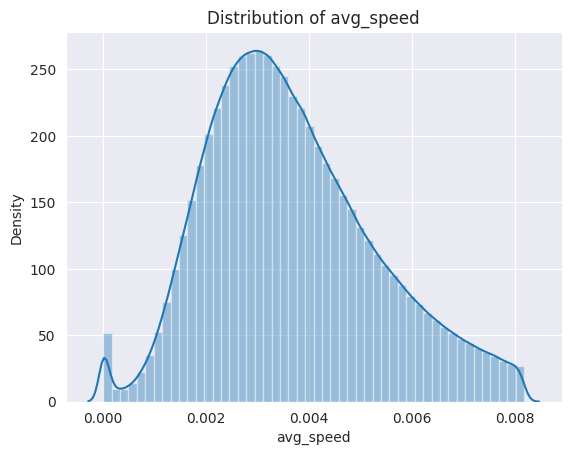

In [25]:
mask = (train_data['avg_speed'] < np.quantile(train_data['avg_speed'], 0.95))
sns.distplot(train_data[mask]['avg_speed'])
plt.title("Distribution of avg_speed")
plt.show()

Для каждой пары (день недели, час суток) посчитаем медиану скоростей

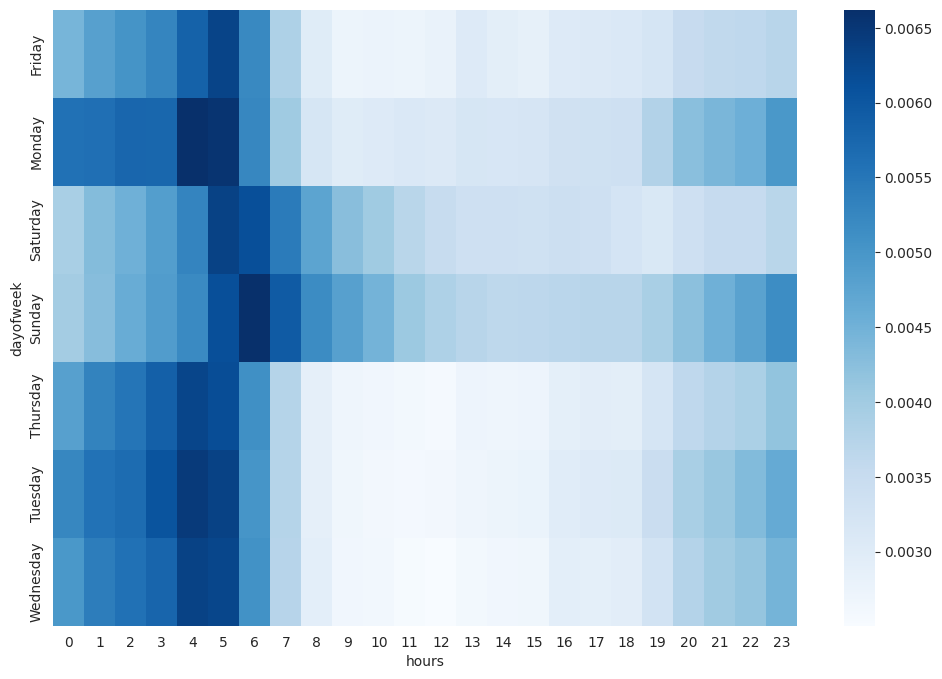

In [26]:
grouped_df = pd.pivot_table(data = train_data, index = 'dayofweek', values = 'avg_speed', columns = 'hours', aggfunc='median')
plt.figure(figsize=(12,8))
sns.heatmap(grouped_df, cmap='Blues')
plt.show()

Удалим колонку со значением скорости из данных, поскольку значение скорости зависит от целевой переменной, поэтому этот признак нельзя использовать во время обучения.

In [27]:
train_data.drop(columns = 'avg_speed', inplace = True)

In [28]:
day_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
           'Friday': 4, 'Saturday': 5, 'Sunday': 6}

def is_rush_hour(row):
    if day_map[row['dayofweek']] < 5  and ((7 <= row['hours'] <= 11) or (16 <= row['hours'] <= 19)):
        return 1
    return 0

def is_free_traffic(row):
    return 1 if is_rush_hour(row) == 0 else 0

train_data['rush_hour'] = train_data.apply(is_rush_hour, axis=1)
train_data['free_traffic'] = train_data.apply(is_free_traffic, axis=1)

### Определение точек с аномальными координатами
На карте выше выделяются две точки вдали от Манхэттена (несложно увидеть, что это два аэропорта). Для каждой из них мы добавим в выборку два признака: началась ли поездка в этой точке и закончилась ли она в ней.

In [29]:
airport1_lat, airport1_lon = 40.6413, -73.7781  # JFK
airport2_lat, airport2_lon = 40.7769, -73.8740  # LGA

def is_near_airport(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon, airport_lat, airport_lon, threshold_km=1):
    distances_pickup = haversine_array(pickup_lat, pickup_lon,
                                       np.full_like(pickup_lat, airport_lat),
                                       np.full_like(pickup_lon, airport_lon))
    distances_dropoff = haversine_array(dropoff_lat, dropoff_lon,
                                        np.full_like(dropoff_lat, airport_lat),
                                        np.full_like(dropoff_lon, airport_lon))
    return (distances_pickup < threshold_km) | (distances_dropoff < threshold_km)

train_data['start_at_airport1'] = haversine_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values,
                                             np.full_like(train_data['pickup_latitude'].values, airport1_lat),
                                             np.full_like(train_data['pickup_longitude'].values, airport1_lon)) < 1

train_data['end_at_airport1'] = haversine_array(train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values,
                                           np.full_like(train_data['dropoff_latitude'].values, airport1_lat),
                                           np.full_like(train_data['dropoff_longitude'].values, airport1_lon)) < 1

train_data['start_at_airport2'] = haversine_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values,
                                             np.full_like(train_data['pickup_latitude'].values, airport2_lat),
                                             np.full_like(train_data['pickup_longitude'].values, airport2_lon)) < 1

train_data['end_at_airport2'] = haversine_array(train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values,
                                           np.full_like(train_data['dropoff_latitude'].values, airport2_lat),
                                           np.full_like(train_data['dropoff_longitude'].values, airport2_lon)) < 1

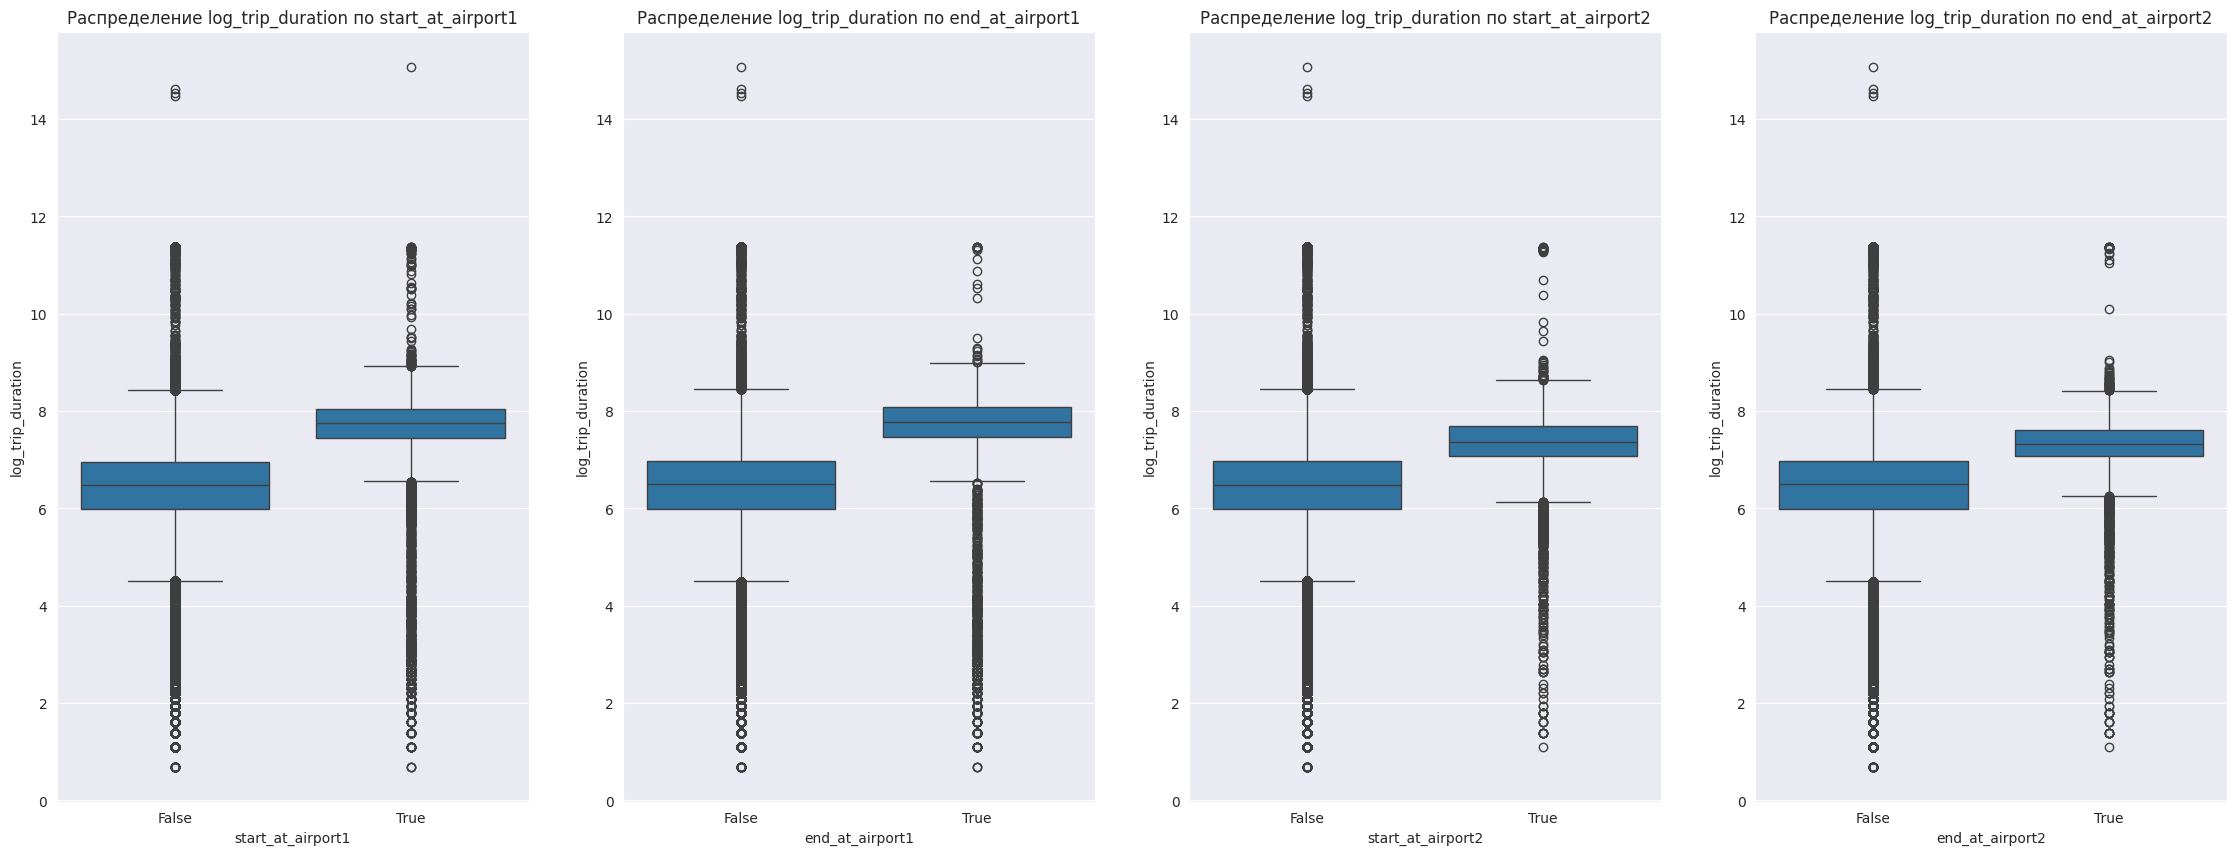

In [30]:
fig, axs = plt.subplots(figsize = (28,10), ncols = 4)
for i, feature in enumerate(['start_at_airport1', 'end_at_airport1', 'start_at_airport2', 'end_at_airport2']):
  sns.boxplot(data = train_data, x = feature, y = 'log_trip_duration', ax = axs[i])
  axs[i].set_title(f'Распределение log_trip_duration по {feature}')
plt.show()

 Распределения для значений различаются по медианам и квартилям, поэтому этот признак достаточно информативен и хорошо разделяет данные

### Разбиение области Манхэттена на карте на ячейки

Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, grid_size=50):
        self.grid_size = grid_size
        self.lat_bins = None
        self.lon_bins = None
        self.categories_ = None

    def _cell_number(self, lat, lon):
        lat_idx = np.digitize(lat, self.lat_bins)
        lon_idx = np.digitize(lon, self.lon_bins)
        return lat_idx * (len(self.lon_bins) - 1) + lon_idx

    def fit(self, X, y=None):
        lat = np.concatenate([X['pickup_latitude'], X['dropoff_latitude']])
        lon = np.concatenate([X['pickup_longitude'], X['dropoff_longitude']])
        self.lat_bins = np.linspace(np.min(lat), np.max(lat), self.grid_size + 1)
        self.lon_bins = np.linspace(np.min(lon), np.max(lon), self.grid_size + 1)
        cells = self._cell_number(lat, lon)
        unique_cells = np.unique(cells)
        self.categories_ = [unique_cells, unique_cells]
        return self

    def transform(self, X):
        start_cells = self._cell_number(X['pickup_latitude'], X['pickup_longitude'])
        end_cells = self._cell_number(X['dropoff_latitude'], X['dropoff_longitude'])
        return np.c_[start_cells, end_cells]

### Изучаем оставшиеся признаки

In [32]:
train_data[['vendor_id', 'passenger_count', 'store_and_fwd_flag']].nunique()

,0
vendor_id,2
passenger_count,10
store_and_fwd_flag,2


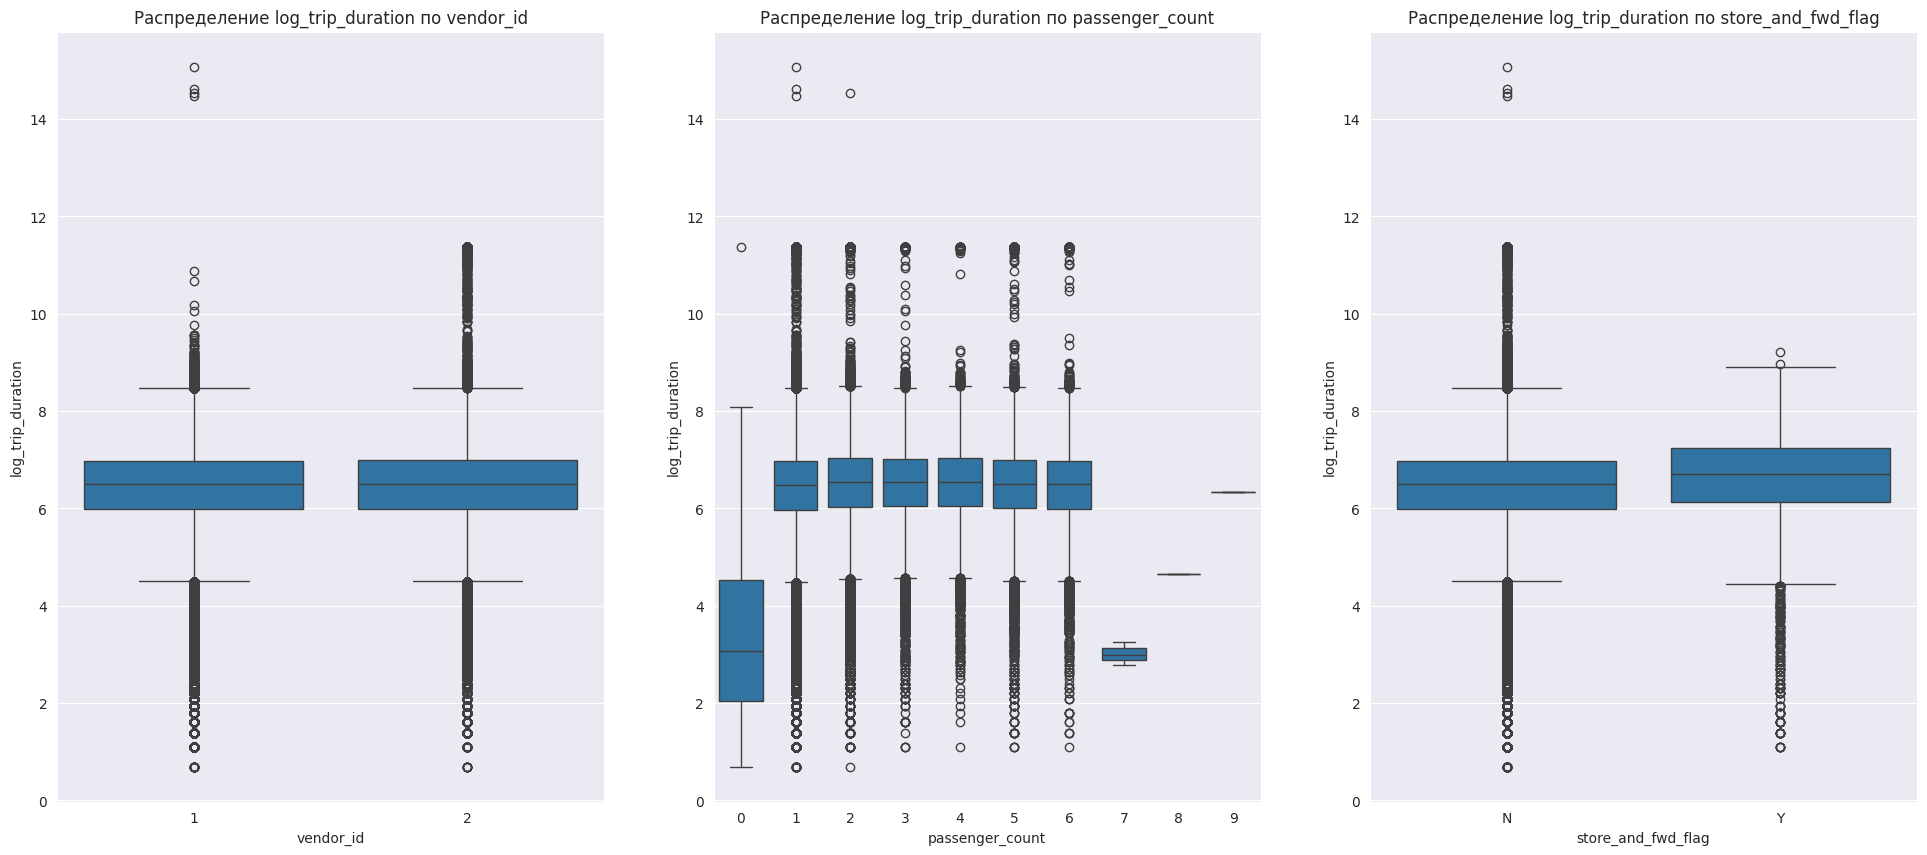

In [33]:
fig, axs = plt.subplots(figsize = (24,10), ncols = 3)
for i, feature in enumerate(['vendor_id', 'passenger_count', 'store_and_fwd_flag']):
  sns.boxplot(data = train_data, x = feature, y = 'log_trip_duration', ax = axs[i])
  axs[i].set_title(f'Распределение log_trip_duration по {feature}')

In [34]:
train_data['vendor_id'] = train_data['vendor_id'].map({1: 0, 2: 1})
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

### Feature Engineering
Создаем новые признаки: пары маршрутов и манхэттенское расстояние

Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Теперь мы осчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

In [35]:
from sklearn.preprocessing import LabelEncoder
class RoutePairTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, map_grid, start_coord_cols, end_coord_cols, top_n=100):
        self.map_grid = map_grid
        self.start_coord_cols = start_coord_cols
        self.end_coord_cols = end_coord_cols
        self.top_n = top_n
        self.top_pairs_ = None
        self.encoder = LabelEncoder()

    def _to_dataframe(self, X):
        if isinstance(X, pd.DataFrame):
            return X
        cols = self.start_coord_cols + self.end_coord_cols
        return pd.DataFrame(X, columns=cols)

    def fit(self, X, y=None):
        X_df = self._to_dataframe(X)
        self.map_grid.fit(X_df)

        start_cells = self.map_grid._cell_number(X_df['pickup_latitude'], X_df['pickup_longitude'])
        end_cells = self.map_grid._cell_number(X_df['dropoff_latitude'], X_df['dropoff_longitude'])

        pairs = np.char.add(start_cells.astype(str), '_')
        pairs = np.char.add(pairs, end_cells.astype(str))
        pairs_series = pd.Series(pairs.flatten())

        top_pairs = pairs_series.value_counts().head(self.top_n).index
        self.top_pairs_ = set(top_pairs)
        self.encoder.fit(list(self.top_pairs_) + ['-1'])
        return self

    def transform(self, X):
        X_df = self._to_dataframe(X)
        start_cells = self.map_grid._cell_number(X_df['pickup_latitude'], X_df['pickup_longitude'])
        end_cells = self.map_grid._cell_number(X_df['dropoff_latitude'], X_df['dropoff_longitude'])

        pairs = np.char.add(start_cells.astype(str), '_')
        pairs = np.char.add(pairs, end_cells.astype(str))

        encoded = [p if p in self.top_pairs_ else '-1' for p in pairs.flatten()]
        encoded = self.encoder.transform(encoded)
        return encoded.reshape(-1, 1)

route_pair_transformer = RoutePairTransformer(
    map_grid=MapGridTransformer(),
    start_coord_cols=['pickup_longitude', 'pickup_latitude'],
    end_coord_cols=['dropoff_longitude', 'dropoff_latitude'],
    top_n=100
)

Этот признак полезен, потому что учитывает взаимодействие старта и финиша поездки, которое линейная модель не может автоматически выявить через раздельные признаки — она видит только независимые влияния, а не их комбинацию.

### Манхэттенское расстояние

In [36]:
train_data['manhattan'] = np.abs(train_data['dropoff_longitude'] - train_data['pickup_longitude']) + np.abs(train_data['dropoff_latitude'] - train_data['pickup_latitude'])
train_data['log_manhattan'] = np.log1p(train_data['manhattan'])

correlations_manh = train_data[['manhattan', 'log_manhattan']].corrwith(train_data['log_trip_duration'])
correlations_manh

,0
manhattan,0.562667
log_manhattan,0.616520


## Моделирование: линейная регрессия с регуляризацией

In [37]:
train, test = train_test_split(train_data, train_size=0.7, random_state = 15)

Сначала обучим модель только на временных признаках

In [38]:
categorical_features_1 = ['anomal_day', 'dayofweek', 'month']
numeric_features_1 = ['dayofyear', 'hours']
selected_features_1 = categorical_features_1 + numeric_features_1

y_train, y_test = train['log_trip_duration'], test['log_trip_duration']
X_train, X_test = train[selected_features_1], test[selected_features_1]

column_transformer_1 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features_1),
    ('scaling', StandardScaler(), numeric_features_1)
])

pipeline_1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_1),
    ('regression', Ridge())
])

model_1 = pipeline_1.fit(X_train, y_train)
y_pred_train_1 = model_1.predict(X_train)
y_pred_1 = model_1.predict(X_test)

print("Train RMSLE = %.4f" % np.sqrt(mean_squared_error(y_train, y_pred_train_1)))
print("Test RMSLE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_1)))

Train RMSLE = 0.7922
Test RMSLE = 0.7936


Добавим еще выделенные нами полезные признаки

In [39]:
categorical_features_2 = ['anomal_day', 'dayofweek', 'month', 'start_at_airport1', 'end_at_airport1', 'start_at_airport2', 'end_at_airport2', 'rush_hour', 'free_traffic']
numeric_features_2 = ['dayofyear', 'hours', 'log_haversine', 'log_manhattan']
coord_features_2 = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
selected_features_2 = categorical_features_2 + numeric_features_2 + coord_features_2

y_train, y_test = train['log_trip_duration'], test['log_trip_duration']
X_train, X_test = train[selected_features_2], test[selected_features_2]

route_pair_transformer = RoutePairTransformer(
    map_grid=MapGridTransformer(),
    start_coord_cols=['pickup_longitude', 'pickup_latitude'],
    end_coord_cols=['dropoff_longitude', 'dropoff_latitude'],
    top_n=100
)

column_transformer_2 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features_2),
    ('scaling', StandardScaler(), numeric_features_2),
    ('route_pairs', route_pair_transformer, coord_features_2)
])

pipeline_2 = Pipeline(steps=[
    ('ohe_and_scaling_and_coord', column_transformer_2),
    ('regression', Ridge())
])

model_2 = pipeline_2.fit(X_train, y_train)
y_pred_train_2 = model_2.predict(X_train)
y_pred_2 = model_2.predict(X_test)

print("Train RMSLE = %.4f" % np.sqrt(mean_squared_error(y_train, y_pred_train_2)))
print("Test RMSLE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_2)))

Train RMSLE = 0.5011
Test RMSLE = 0.5042


In [40]:
categorical_features_3 = ['anomal_day', 'dayofweek', 'month', 'start_at_airport1', 'end_at_airport1', 'start_at_airport2', 'end_at_airport2', 'rush_hour', 'free_traffic', 'vendor_id', 'store_and_fwd_flag']
numeric_features_3 = ['dayofyear', 'hours', 'log_haversine', 'passenger_count', 'log_manhattan']
coord_features_3 = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
selected_features_3 = categorical_features_3 + numeric_features_3 + coord_features_3

train, test = train_test_split(train_data, train_size=0.7, random_state = 15)
y_train, y_test = train['log_trip_duration'], test['log_trip_duration']
X_train, X_test = train[selected_features_3], test[selected_features_3]

column_transformer_3 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features_3),
    ('scaling', StandardScaler(), numeric_features_3),
    ('route_pairs', route_pair_transformer, coord_features_3)
])

pipeline_3 = Pipeline(steps=[
    ('ohe_and_scaling_and_coord', column_transformer_3),
    ('regression', Ridge())
])

model_3 = pipeline_3.fit(X_train, y_train)
y_pred_train_3 = model_3.predict(X_train)
y_pred_3 = model_3.predict(X_test)

print("Train RMSLE = %.4f" % np.sqrt(mean_squared_error(y_train, y_pred_train_3)))
print("Test RMSLE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_3)))

Train RMSLE = 0.5009
Test RMSLE = 0.5040


Добавление признаков `vendor_id`, `store_and_fwd_flag` и `passenger_count` не дало какого-то ощутимого улучшения метрики, поэтому их можно убрать из данных, чтобы не допустить переобучения модели.

In [41]:
categorical_features_3 = ['anomal_day', 'dayofweek', 'month', 'start_at_airport1', 'end_at_airport1', 'start_at_airport2', 'end_at_airport2', 'rush_hour', 'free_traffic']
numeric_features_3 = ['dayofyear', 'hours', 'log_haversine', 'log_manhattan']
coord_features_3 = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
selected_features_3 = categorical_features_3 + numeric_features_3 + coord_features_3

In [42]:
y_train, y_test = train['log_trip_duration'], test['log_trip_duration']
X_train, X_test = train[selected_features_3], test[selected_features_3]


column_transformer_3 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features_3),
    ('scaling', StandardScaler(), numeric_features_3),
    ('route_pairs', route_pair_transformer, coord_features_3)
])
pipeline_3 = Pipeline(steps=[
    ('ohe_and_scaling_and_coord', column_transformer_3),
    ('regression', Ridge())
])

model_3 = pipeline_3.fit(X_train, y_train)
y_pred_train_3 = model_3.predict(X_train)
y_pred_3 = model_3.predict(X_test)

print("Train RMSLE = %.4f" % np.sqrt(mean_squared_error(y_train, y_pred_train_3)))
print("Test RMSLE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_3)))

Train RMSLE = 0.5011
Test RMSLE = 0.5042


# Улучшаем модель

В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии., поэтому нам нужно очистить обучающую выборку от них, чтобы модель получалась более разумной и интерпретируемой.

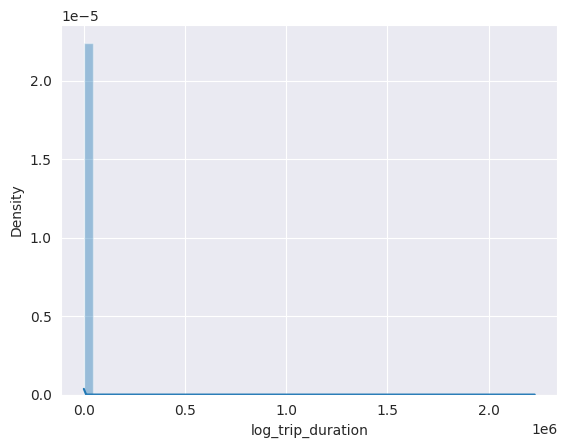

In [43]:
trip_duration_check = np.exp(train['log_trip_duration'])-1
sns.distplot(trip_duration_check)
plt.show()

In [44]:
mask_mini_trip_duration = (trip_duration_check > np.quantile(trip_duration_check, 0.05))

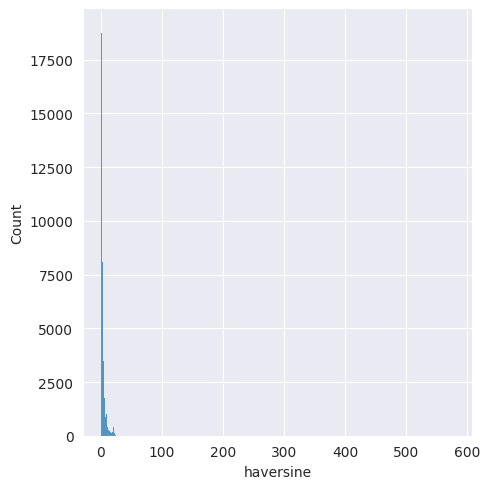

In [45]:
s_check = train['haversine']
sns.displot(s_check)

In [46]:
mask_s = (s_check < np.quantile(s_check, 0.95))

In [47]:
train = train[mask_mini_trip_duration & mask_s]

<Axes: xlabel='log_trip_duration', ylabel='Density'>

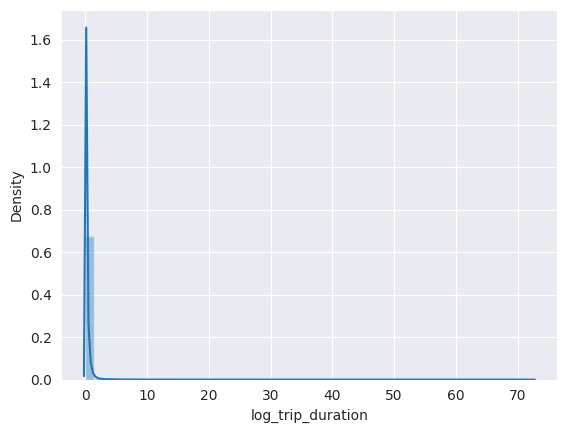

In [48]:
error_reg = (y_train - model_3.predict(X_train)) ** 2
sns.distplot(error_reg)

In [49]:
mask_error_reg = (error_reg < np.quantile(error_reg, 0.95))

In [50]:
model_3 = pipeline_3.fit(X_train[mask_error_reg], y_train[mask_error_reg])
y_pred_train_3 = model_3.predict(X_train[mask_error_reg])
y_pred_3 = model_3.predict(X_test)

print("Train RMLSE = %.4f" % np.sqrt(mean_squared_error(y_train[mask_error_reg], y_pred_train_3)))
print("Test RMSLE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_3)))

Train RMLSE = 0.3668
Test RMSLE = 0.5049


Заметим, что фильтрация выбросов улучшает модель.

In [51]:
from sklearn.linear_model import Lasso

column_transformer_3 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features_3),
    ('scaling', StandardScaler(), numeric_features_3),
    ('coordinates', MapGridTransformer(), coord_features_3)
])

pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling_and_coord', column_transformer_3),
    ('regression', Lasso())
])

model_lasso = pipeline_lasso.fit(X_train[mask_error_reg], y_train[mask_error_reg])
y_pred_train_lasso = model_lasso.predict(X_train[mask_error_reg])
y_pred_lasso = model_lasso.predict(X_test)

print("Train RMSLE with lasso-reg = %.4f" % np.sqrt(mean_squared_error(y_train[mask_error_reg], y_pred_train_lasso)))
print("Test RMSLE with lasso-reg = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

Train RMSLE with lasso-reg = 0.6874
Test RMSLE with lasso-reg = 0.7900


Разобьем обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберем оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измеримс качество лучшей полученной модели.

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, random_state = 15)

y_pred_valid = model_3.predict(X_valid)
error_reg_valid = (y_valid - y_pred_valid) ** 2
mask_error_reg_valid = (error_reg_valid < np.quantile(error_reg_valid, 0.95))
X_valid_filtered = X_valid[mask_error_reg_valid]
y_valid_filtered = y_valid[mask_error_reg_valid]


alphas = np.logspace(-2, 3, 15)
searcher_ridge = GridSearchCV(pipeline_3, [{"regression__alpha": alphas}], scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
searcher_ridge.fit(X_valid_filtered, y_valid_filtered)
best_alpha_ridge = searcher_ridge.best_params_['regression__alpha']
print(f"Best alpha for Ridge-reg = {best_alpha_ridge:.4f}")

column_transformer_3 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features_3),
    ('scaling', StandardScaler(), numeric_features_3),
    ('route_pairs', route_pair_transformer, coord_features_3)
])

pipeline_3_l2 = Pipeline(steps=[
    ('ohe_and_scaling_and_coord', column_transformer_3),
    ('regression', Ridge(best_alpha_ridge))
])

model_3_l2 = pipeline_3_l2.fit(X_train[mask_error_reg], y_train[mask_error_reg])
y_pred_train_3_l2 = model_3_l2.predict(X_train[mask_error_reg])
y_pred_3_l2 = model_3_l2.predict(X_test)

print("Train RMSLE with l2-regularization = %.4f" % np.sqrt(mean_squared_error(y_train[mask_error_reg], y_pred_train_3_l2)))
print("Test RMSLE with l2-regularization = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_3_l2)))

Best alpha for Ridge-reg = 16.3789
Train RMSLE with l2-regularization = 0.3668
Test RMSLE with l2-regularization = 0.5048


In [53]:
y_pred_valid = model_lasso.predict(X_valid)
error_reg_valid = (y_valid - y_pred_valid) ** 2
mask_error_reg_valid = (error_reg_valid < np.quantile(error_reg_valid, 0.95))
X_valid_filtered = X_valid[mask_error_reg_valid]
y_valid_filtered = y_valid[mask_error_reg_valid]


alphas = np.logspace(-2, 3, 15)
searcher_lasso = GridSearchCV(pipeline_lasso, [{"regression__alpha": alphas}], scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
searcher_lasso.fit(X_valid_filtered, y_valid_filtered)
best_alpha_lasso = searcher_lasso.best_params_['regression__alpha']
print(f"Best alpha for Lasso-reg = {best_alpha_lasso:.4f}")

column_transformer_3 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features_3),
    ('scaling', StandardScaler(), numeric_features_3),
    ('route_pairs', route_pair_transformer, coord_features_3)
])

pipeline_lasso_l1 = Pipeline(steps=[
    ('ohe_and_scaling_and_coord', column_transformer_3),
    ('regression', Lasso(best_alpha_lasso))
])

model_lasso_l1 = pipeline_lasso_l1.fit(X_train[mask_error_reg], y_train[mask_error_reg])
y_pred_train_lasso_l1 = model_lasso_l1.predict(X_train[mask_error_reg])
y_pred_lasso_l1 = model_lasso_l1.predict(X_test)

print("Train RMSLE with l1-regularization = %.4f" % np.sqrt(mean_squared_error(y_train[mask_error_reg], y_pred_train_lasso_l1)))
print("Test RMSLE with l1-regularization = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_lasso_l1)))

Best alpha for Lasso-reg = 0.0100
Train RMSLE with l1-regularization = 0.3738
Test RMSLE with l1-regularization = 0.5108


Для каждого перебранного `alpha` для Lasso посчитаем количество нулевых весов в модели и нарисуем график зависимости его от `alpha`.

In [54]:
alphas = np.logspace(-2, 3, 10)
zero_coeff_counts = []
lrmse_values = []

for alpha in alphas:
    pipeline_lasso_l1 = Pipeline(steps=[
        ('ohe_and_scaling_and_coord', column_transformer_3),
        ('regression', Lasso(alpha=alpha, max_iter=10000))
    ])

    pipeline_lasso_l1.fit(X_train[mask_error_reg], y_train[mask_error_reg])

    coefs = pipeline_lasso_l1.named_steps['regression'].coef_
    zero_count = np.sum(coefs == 0)
    zero_coeff_counts.append(zero_count)

    y_pred = pipeline_lasso_l1.predict(X_test)
    lrmse = np.sqrt(mean_squared_error(y_test, y_pred))
    lrmse_values.append(lrmse)

Text(0.5, 1.0, 'Количество нулевых весов в модели в зависимости от $alpha$')

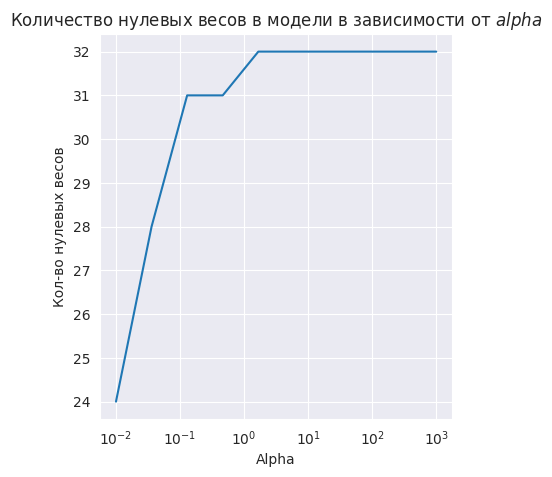

In [55]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(alphas, zero_coeff_counts)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Кол-во нулевых весов')
plt.title('Количество нулевых весов в модели в зависимости от $alpha$')

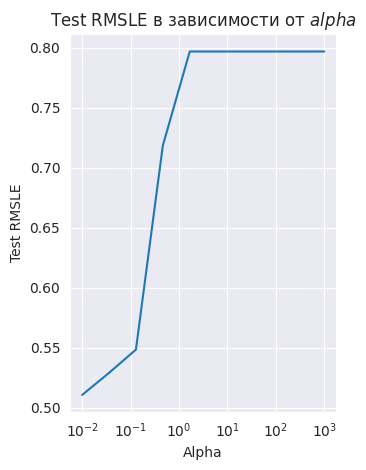

In [56]:
plt.subplot(1, 2, 2)
plt.plot(alphas, lrmse_values)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Test RMSLE')
plt.title('Test RMSLE в зависимости от $alpha$')
plt.tight_layout()
plt.show()

In [57]:
half_zero_index = next(i for i, count in enumerate(zero_coeff_counts) if count >= len(coefs) / 2)
alpha_half_zero = alphas[half_zero_index]
lrmse_half_zero = lrmse_values[half_zero_index]

print(f"Alpha to zero at least half coefficients: {alpha_half_zero:.4f}")
print(f"Test RMSLE at this alpha: {lrmse_half_zero:.4f}")
print(f"Increase in RMSLE relative to minimum: {lrmse_half_zero - min(lrmse_values):.4f}")

Alpha to zero at least half coefficients: 0.0100
Test RMSLE at this alpha: 0.5108
Increase in RMSLE relative to minimum: 0.0000


In [58]:
r2_test = r2_score(y_test, y_pred_3_l2)
print(f"Test R^2: {r2_test:.4f}")

Test R^2: 0.5985


In [59]:
best_constant_test = y_test.mean()
print("Test RMSLE with best constant = %.4f" % np.sqrt(mean_squared_error(y_test, best_constant * np.ones(y_test.shape))))
print("Test RMSLE with l2-regularization = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_3_l2)))

Test RMSLE with best constant = 0.7967
Test RMSLE with l2-regularization = 0.5048


# Улучшение модели: Random Forest
Для улучшения результатов используем нелинейную модель — Random Forest. Это позволит захватить более сложные зависимости.

Мы используем тот же pipeline для препроцессинга, но меняем регрессор на RandomForestRegressor.

In [60]:
from sklearn.ensemble import RandomForestRegressor

pipeline_rf = Pipeline(steps=[
    ('ohe_and_scaling_and_coord', column_transformer_3),
    ('regression', RandomForestRegressor(n_estimators=70, max_depth=8, random_state=15, n_jobs=-1))
])

model_rf = pipeline_rf.fit(X_train[mask_error_reg], y_train[mask_error_reg])

y_pred_train_rf = model_rf.predict(X_train[mask_error_reg])
y_pred_rf = model_rf.predict(X_test)

print("Train RMSLE with Random Forest = %.4f" % np.sqrt(mean_squared_error(y_train[mask_error_reg], y_pred_train_rf)))
print("Test RMSLE with Random Forest = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Train RMSLE with Random Forest = 0.3420
Test RMSLE with Random Forest = 0.4798


In [61]:
r2_test_rf = r2_score(y_test, y_pred_rf)
print(f"Test R^2 with Random Forest: {r2_test_rf:.4f}")

Test R^2 with Random Forest: 0.6373


## Выводы

Значение метрики RMSLE на тестовой выборке составило около 0.5048, что на 36% метрики при лучшем константном предсказанием линейной модели. Это свидетельствует о значительном улучшении качества модели по сравнению со случайным прогнозом.

Коэффициент детерминации (R²) равен примерно 0.6, что оворит о том, что модель объясняет большую часть дисперсии целевой переменной, что является хорошим результатом для задачи с высоким уровнем шума, как предсказание времени поездки

Использование нелинейной модели позволило дополнительно улучшить RMSLE до 0.4798.

Таким образом, полученная модель показала высокую эффективность и может использоваться для надёжного прогнозирования длительности поездки на такси в Нью-Йорке.